In [53]:
import os
import sys
from glob import glob
from pathlib import Path
from tqdm import tqdm
from dotenv import load_dotenv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [54]:
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [55]:
from src.utils.helpers import get_emotion_abrs_from_ids

# Paths

In [56]:
load_dotenv()
output_path = os.getenv("VIDEO_OUT")
# Global configuration path
glob_conf_path = '../global_config.py'

# Load global variables

In [57]:
exec(open(glob_conf_path).read())

# Load and shuffle data

In [58]:
from sklearn.utils import shuffle

train_intensity_df = pd.read_csv(output_path + 'video_data_intensity_train.csv')
train_shuffled_df = shuffle(train_intensity_df, random_state=seed)
train_shuffled_df

,filename,AU01_r_mean,AU01_r_stddevNorm,AU01_r_percentile20.0,AU01_r_percentile50.0,AU01_r_percentile80.0,AU01_r_iqr60_80-20,AU01_r_numPeaks,AU02_r_mean,AU02_r_stddevNorm,...,AU45_r_mean,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,video_id,emotion_1_id,group
71,A101_ang_v_4,0.056085,0.397844,0.0,0.235294,0.036761,0.036761,0.247423,0.037438,0.262750,...,0.017577,0.052481,0.0,0.333333,0.012690,0.012690,0.40,A101,12,14
381,A200_sha_v_2,0.015947,0.309027,0.0,0.235294,0.011168,0.011168,0.144330,0.038481,0.252852,...,0.227794,0.216413,0.0,0.083333,0.199492,0.199492,0.06,A200,43,8
1606,A64_hap_v_3,0.370053,0.660400,0.0,0.235294,0.111215,0.111215,0.061856,0.293802,0.451970,...,0.080214,0.210988,0.0,0.250000,0.056853,0.056853,0.08,A64,33,12
1855,A74_hap_p_3,0.106663,0.338433,0.0,0.117647,0.096789,0.096789,0.134021,0.082483,0.337758,...,0.231146,0.204194,0.0,0.000000,0.196447,0.196447,0.12,A74,33,14
968,A26_disg_p_1,0.024236,0.354060,0.0,0.235294,0.018148,0.018148,0.103093,0.021576,0.298000,...,0.101379,0.672777,0.0,0.166667,0.020305,0.020305,0.05,A26,35,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,A74_gui_p_4,0.176925,0.314282,0.0,0.000000,0.131224,0.131224,0.175258,0.181291,0.454178,...,0.169011,0.156804,0.0,0.000000,0.121320,0.121320,0.14,A74,40,14
543,A207_gui_v_4,0.142171,0.273825,0.0,0.000000,0.136808,0.136808,0.175258,0.046983,0.267344,...,0.047798,0.234371,0.0,0.250000,0.020305,0.020305,0.18,A207,40,4
1864,A74_int_p_4,0.106466,0.328470,0.0,0.352941,0.098185,0.098185,0.185567,0.195890,0.479611,...,0.061151,0.133127,0.0,0.166667,0.050761,0.050761,0.24,A74,29,14
1720,A67_gui_p_2,0.030829,0.425877,0.0,0.235294,0.018148,0.018148,0.175258,0.042596,0.286288,...,0.186215,0.479520,0.0,0.000000,0.069036,0.069036,0.17,A67,40,13


# Define confusion matrix functions

In [59]:
from sklearn.metrics import confusion_matrix

def calculate_conf_matrix(X_train, X_val, y_train, y_val, clf):
    # train classifier on training sets 
    clf.fit(X_train,y_train)

    # Compute results (validation dataset)    
    y_pred = clf.predict(X_val)                       # Predict class

    # compare true validation results (y_val) with prediction (y_pred)
    # Compute confusion matrix
    return confusion_matrix(y_val,
                            y_pred,
                            normalize='true'
                            )
    

In [60]:
def iterate_conf_matrices(size, X, y, cv, clf):
    # Initialize a matrix of zeros to store results
    conf_mat_avg = np.zeros([size, size])
    n_groups = 0
    for train_idx, val_idx in cv:
        n_groups += 1
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        conf_mat_avg += calculate_conf_matrix(X_train, X_val, y_train, y_val, clf)
    
    # compute the average scores by dividing with number of groups
    return conf_mat_avg/n_groups

In [61]:
def get_conf_matrix(X, y, cv, clf):
    """
    Produces a confusion matrix by iterating and averageing the confusion matrix for each validation set
    :return: confusion matrix in the form of a dataframe
    """
    # get emotion_ids
    emotion_ids = y.unique()
    
    # compute the average scores by dividing with number of groups
    conf_mat_avg = iterate_conf_matrices(len(emotion_ids), X, y, cv, clf,)
    
    # get emotion abreviations
    emotion_abrs = get_emotion_abrs_from_ids(emotion_ids)
    
    # create dataframe with lists of emotion ids as row and column names
    df_cm = pd.DataFrame(conf_mat_avg, list(emotion_abrs), list(emotion_abrs))
    
    # sort columns
    df_cm = df_cm.reindex(sorted(df_cm.columns)).reindex(sorted(df_cm.columns), axis=1)
    
    return df_cm

In [62]:
def plot_conf_matrix(df_cm, title):
    plt.figure(figsize=(15,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)

In [63]:
def save_conf_matrix(file_name):
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')       

# Define score functions

In [64]:
def evaluate_scores(X, y, groups, clf, scoring_method):
    # get scores
    scores = cross_validate(X=X, y=y,
                            estimator           = clf,
                            scoring             = [scoring_method],
                            cv                  = logo.split(X=X,groups=groups),
                            verbose             = 1,
                            n_jobs              = -1,
                            return_train_score  = True                        
                           )
    
    print('printing {} measures'.format(scoring_method))
    print('avg (train):', np.mean(scores['train_{}'.format(scoring_method)]))
    print('std (train):', np.std(scores['train_{}'.format(scoring_method)]))
    print('avg (validation):', np.mean(scores['test_{}'.format(scoring_method)]))
    print('std (validation):', np.std(scores['test_{}'.format(scoring_method)]))

# Training and testing

### Get X, y and groups from the training data set

In [65]:
# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=["filename", "video_id", "emotion_1_id", "group"])
y = train_shuffled_df.emotion_1_id
groups = train_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()

### Elastic Net

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


printing accuracy measures
avg (train): 0.4161511516441991
std (train): 0.022230632504729942
avg (validation): 0.3183221960743003
std (validation): 0.035327286531058724


/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 298, in _score
    y_pred = method_caller(clf, "predict_proba", X)
  File "/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/tim/anaconda3/envs/t

printing roc_auc_ovo_weighted measures
avg (train): nan
std (train): nan
avg (validation): nan
std (validation): nan


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.8s finished


printing recall_macro measures
avg (train): 0.4170517663154797
std (train): 0.01682536956439568
avg (validation): 0.3063872122106086
std (validation): 0.04492642830860315


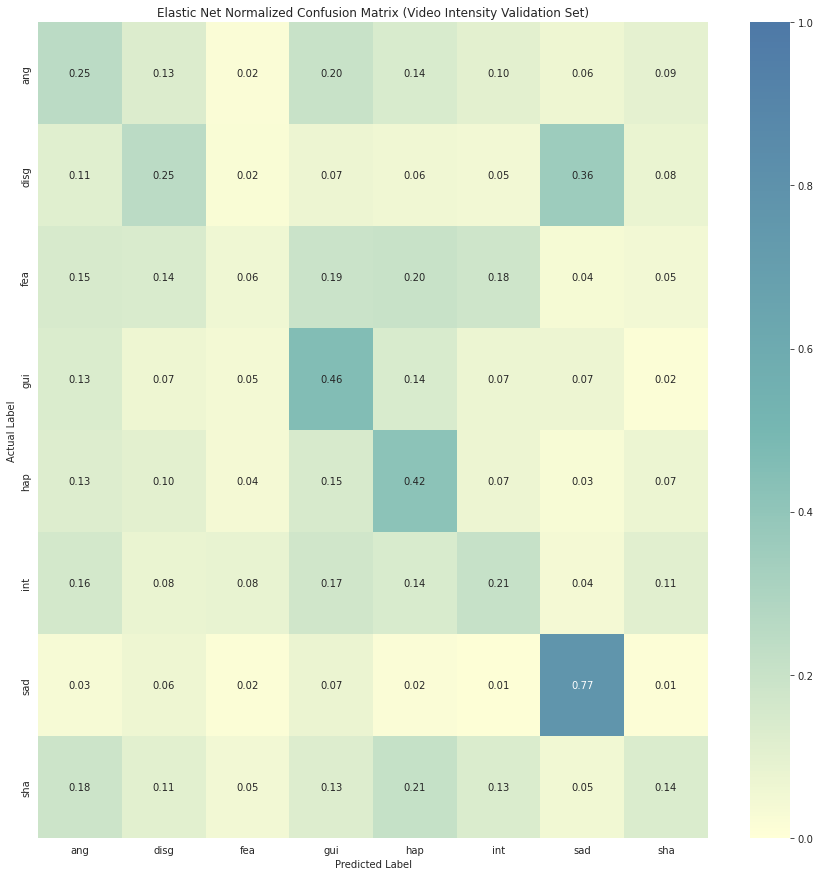

In [66]:
# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = SGDClassifier(**best_params)

evaluate_scores(X, y, groups, clf, 'accuracy')
evaluate_scores(X, y, groups, clf, 'roc_auc_ovo_weighted')
evaluate_scores(X, y, groups, clf, 'recall_macro')

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='Elastic Net Normalized Confusion Matrix (Video Intensity Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_elastic_net_intensity_video.svg')


## kNN

TODO: Might be smart to seed such that every emotion has it's own cluster starting point

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


printing accuracy measures
avg (train): 0.6042801220774181
std (train): 0.004091150799833684
avg (validation): 0.2608595475880422
std (validation): 0.04984672672290256


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


printing roc_auc_ovo_weighted measures
avg (train): 0.9279495228835432
std (train): 0.0008322353278159177
avg (validation): 0.6467812994863904
std (validation): 0.03669710562193235


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.1s finished


printing recall_macro measures
avg (train): 0.6051363076080856
std (train): 0.004134020676490281
avg (validation): 0.2608040109941837
std (validation): 0.051250205740106115


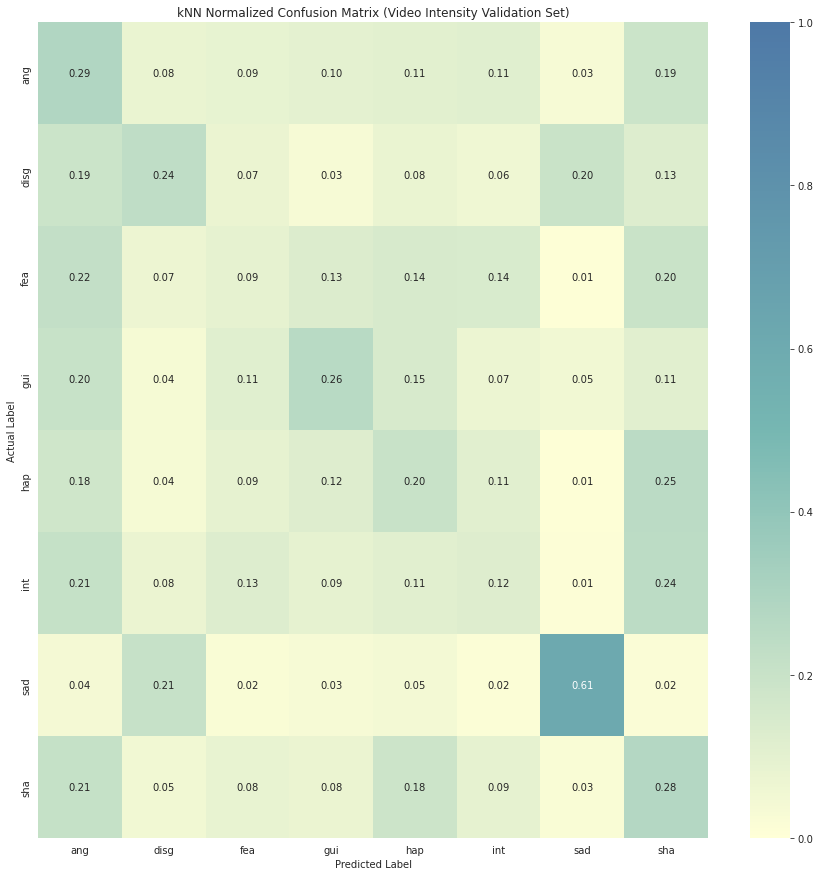

In [67]:
# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_knn_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = KNeighborsClassifier(**best_params)

evaluate_scores(X, y, groups, clf, 'accuracy')
evaluate_scores(X, y, groups, clf, 'roc_auc_ovo_weighted')
evaluate_scores(X, y, groups, clf, 'recall_macro')

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='kNN Normalized Confusion Matrix (Video Intensity Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_knn_intensity_video.svg')

## Decision Tree


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


printing accuracy measures
avg (train): 0.9965121307378629
std (train): 0.0009013671800425713
avg (validation): 0.24144872973446113
std (validation): 0.03242232096445078


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


printing roc_auc_ovo_weighted measures
avg (train): 0.9999850577219902
std (train): 3.869210888859386e-06
avg (validation): 0.5695923622064463
std (validation): 0.019968989091349795


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.0s finished


printing recall_macro measures
avg (train): 0.9964719659972673
std (train): 0.0009115692452084602
avg (validation): 0.25858598714273057
std (validation): 0.025721777612869503


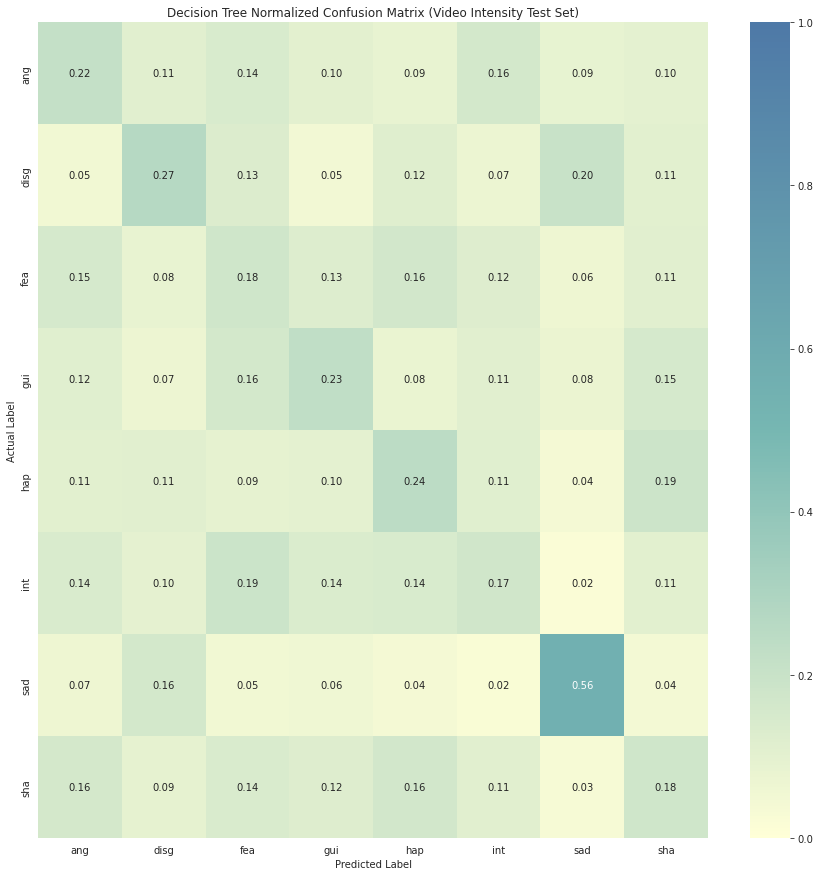

In [69]:
# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_decision_tree_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = DecisionTreeClassifier(**best_params)

evaluate_scores(X, y, groups, clf, 'accuracy')
evaluate_scores(X, y, groups, clf, 'roc_auc_ovo_weighted')
evaluate_scores(X, y, groups, clf, 'recall_macro')

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='Decision Tree Normalized Confusion Matrix (Video Intensity Test Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_tree_intensity_video.svg')

## Random Forest

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


printing accuracy measures
avg (train): 0.9965121307378629
std (train): 0.0009013671800425713
avg (validation): 0.32982063199845824
std (validation): 0.043008939479672756


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


printing roc_auc_ovo_weighted measures
avg (train): 0.9999843003174502
std (train): 4.322680523961139e-06
avg (validation): 0.7468114155362628
std (validation): 0.03225020310527809


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    7.1s finished


printing recall_macro measures
avg (train): 0.9964849154065991
std (train): 0.0009081252580498414
avg (validation): 0.3288199858666553
std (validation): 0.0487798550237545


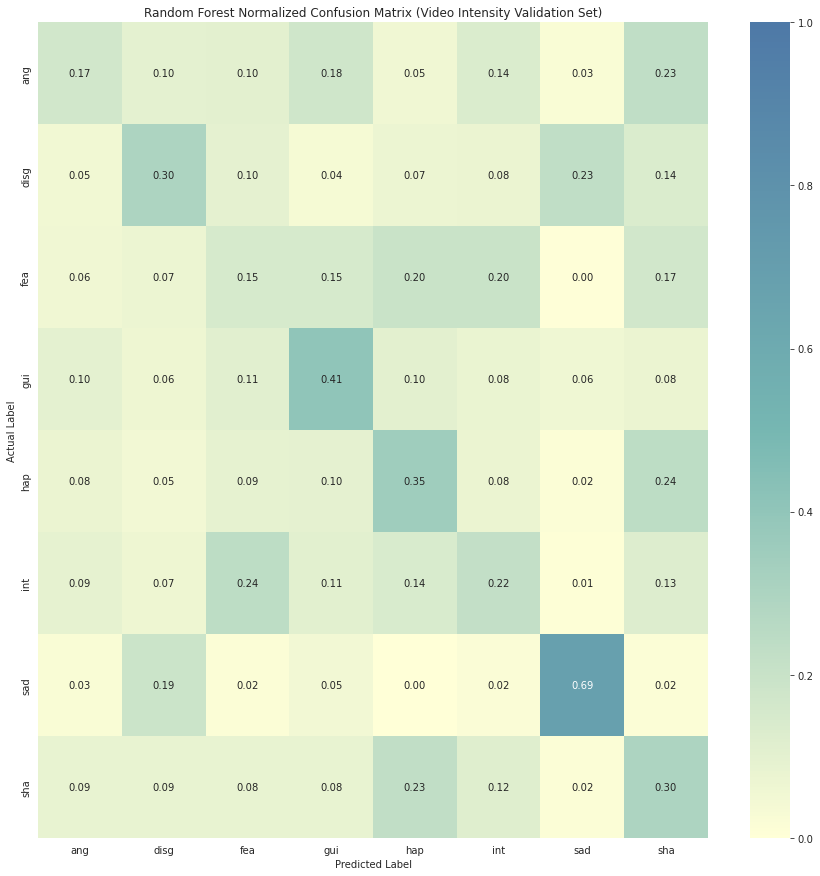

/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 298, in _score
    y_pred = method_caller(clf, "predict_proba", X)
  File "/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/tim/anaconda3/envs/t

In [70]:
# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_rf_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = RandomForestClassifier(**best_params)

evaluate_scores(X, y, groups, clf, 'accuracy')
evaluate_scores(X, y, groups, clf, 'roc_auc_ovo_weighted')
evaluate_scores(X, y, groups, clf, 'recall_macro')

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='Random Forest Normalized Confusion Matrix (Video Intensity Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_rf_intensity_video.svg')